In [13]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from transformers import BertTokenizer
import torch

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import string

In [15]:
data = pd.read_csv("train.csv")

In [16]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


DATA PREPROCESSING USING NLTK


In [17]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [19]:
data = data.dropna()

In [20]:
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [21]:
# Convert the 'text' column to string type using apply, to ensure compatibility
data['text'] = data['text'].apply(lambda x: str(x))

# Convert text to lowercase using apply with a lambda function
data['text'] = data['text'].apply(lambda x: x.lower())

In [22]:
data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
#tokeniztion
data['text'] = data['text'].apply(nltk.word_tokenize)


In [25]:
#stopwords
stop = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stop])

In [26]:
#lemmatization
lemmatizer = WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [27]:
#join back text into string
data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [28]:
#form vectors using tf-idf
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(data['text']).toarray()
y = data['label']

In [29]:
#split the data into train nd test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL BUILDING WITH LOGISTICREGRESSION

In [64]:
#recall the model and fit the training data into it
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [65]:
#predict the label on x_test /testing data
y_pred = logistic_model.predict(X_test)
#print the classification reporth
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6387749521465682
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      2082
           1       0.61      0.46      0.52      1575

    accuracy                           0.64      3657
   macro avg       0.63      0.62      0.62      3657
weighted avg       0.63      0.64      0.63      3657



MODEL BUILDING WITH LSTM(LONG-SHORT TERM MEMORY)

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [34]:
# Step 2: Prepare data for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

In [35]:
# Pad sequences to ensure consistent input length
X = pad_sequences(sequences, maxlen=200)
y = data['label']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Step 3: Build the LSTM model
LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))  # Embedding layer
LSTM_model.add(LSTM(128, return_sequences=True))  # LSTM layer with 128 units
LSTM_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
LSTM_model.add(LSTM(64))  # Another LSTM layer with 64 units
LSTM_model.add(Dense(1, activation='sigmoid'))

c:\Users\ayush\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [68]:
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [69]:
history = LSTM_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy: 0.8199 - loss: 0.3763 - val_accuracy: 0.8999 - val_loss: 0.2970
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.9603 - loss: 0.1211 - val_accuracy: 0.9320 - val_loss: 0.1914
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.9796 - loss: 0.0694 - val_accuracy: 0.9320 - val_loss: 0.1982
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - accuracy: 0.9804 - loss: 0.0597 - val_accuracy: 0.9368 - val_loss: 0.2130
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 51s 277ms/step - accuracy: 0.9924 - loss: 0.0247 - val_accuracy: 0.9416 - val_loss: 0.2370


In [70]:
y_pred = (LSTM_model.predict(X_test) > 0.5).astype("int32")

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step


In [71]:
# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9507793273174734
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2082
           1       0.96      0.93      0.94      1575

    accuracy                           0.95      3657
   macro avg       0.95      0.95      0.95      3657
weighted avg       0.95      0.95      0.95      3657



In [72]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Confusion Matrix:
[[2020   62]
 [ 118 1457]]


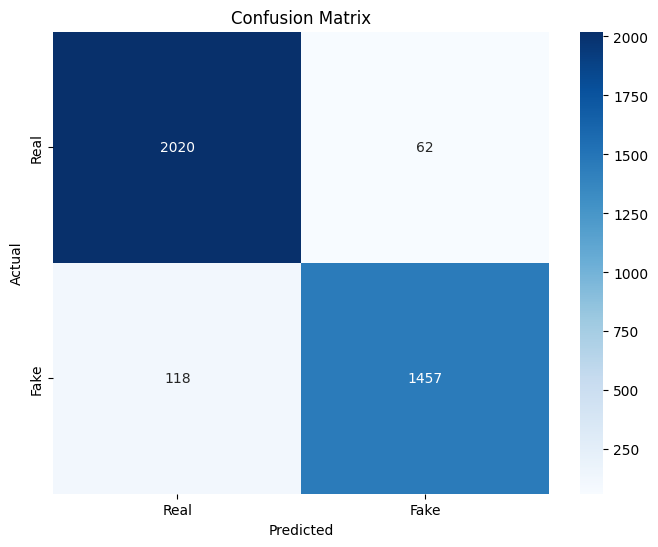

In [73]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print and plot the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

MODEL BUILDING USING RNN

In [50]:
from tensorflow.keras.layers import SimpleRNN

In [51]:
# Step 2: Prepare data for RNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])


In [52]:
# Pad sequences to ensure consistent input length
X = pad_sequences(sequences, maxlen=200)
y = data['label']

In [53]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Step 3: Build the RNN model
RNN_Model = Sequential()
RNN_Model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))  # Embedding layer
RNN_Model.add(SimpleRNN(128, return_sequences=True))  # RNN layer with 128 units
RNN_Model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
RNN_Model.add(SimpleRNN(64))  # Another RNN layer with 64 units
RNN_Model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


c:\Users\ayush\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
# Compile the model
RNN_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
# Train the model
history = RNN_Model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.6509 - loss: 0.5900 - val_accuracy: 0.9043 - val_loss: 0.2529
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9113 - loss: 0.2321 - val_accuracy: 0.9087 - val_loss: 0.2353
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9217 - loss: 0.2206 - val_accuracy: 0.8794 - val_loss: 0.2862
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9378 - loss: 0.1679 - val_accuracy: 0.9019 - val_loss: 0.2692
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9413 - loss: 0.1781 - val_accuracy: 0.9026 - val_loss: 0.2905


In [77]:
# Predict and evaluate
y_pred = (RNN_Model.predict(X_test) > 0.5).astype("int32")

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [78]:
# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9116762373530216
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2082
           1       0.88      0.91      0.90      1575

    accuracy                           0.91      3657
   macro avg       0.91      0.91      0.91      3657
weighted avg       0.91      0.91      0.91      3657



Confusion Matrix:
[[1895  187]
 [ 136 1439]]


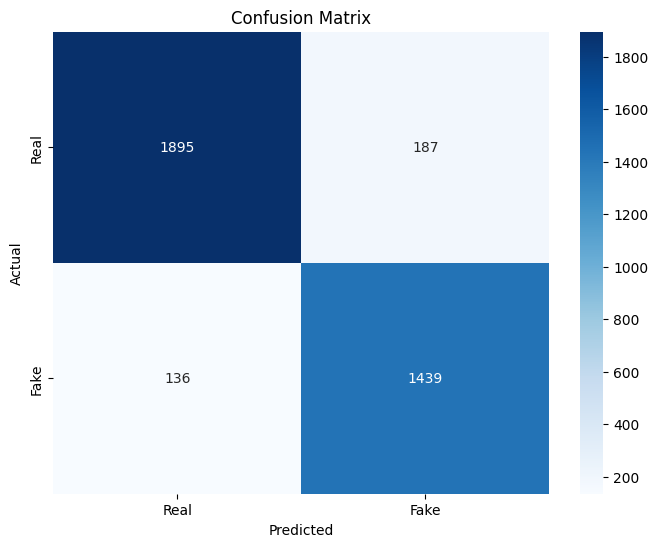

In [79]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print and plot the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TESTING THE MODEL USING (RNN, LogisticRegression , LSTM)

In [80]:
#input
new_news = ["House Dem Aide: We Didn’t Even See Comey’s Letter Before it was released to the media"]

In [81]:
# Step 1: Preprocess the input news article
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)


In [82]:
# Preprocess the new news article
preprocessed_news = [preprocess_text(news) for news in new_news]
news_sequences = tokenizer.texts_to_sequences(preprocessed_news)
news_padded = pad_sequences(news_sequences, maxlen=200)


In [83]:
# Logistic Regression Model Prediction
logistic_pred = logistic_model.predict(news_padded)
logistic_label = "Fake" if logistic_pred[0] > 0.5 else "Real"


In [85]:
# LSTM Model Prediction
lstm_pred = LSTM_model.predict(news_padded)
lstm_label = "Fake" if lstm_pred[0] > 0.5 else "Real"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [86]:
# RNN Model Prediction
rnn_pred = RNN_Model.predict(news_padded)
rnn_label = "Fake" if rnn_pred[0] > 0.5 else "Real"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [87]:
# Step 3: Print the results
print(f"Logistic Regression Prediction: {logistic_label}")
print(f"LSTM Model Prediction: {lstm_label}")
print(f"RNN Model Prediction: {rnn_label}")

Logistic Regression Prediction: Fake
LSTM Model Prediction: Fake
RNN Model Prediction: Fake
